# Maps of RMSSSH

In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c

/Users/auraoupa/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Client Scheduler: tcp://127.0.0.1:49569 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


## 0. Modules and libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os 
import time 
import glob


import numpy as np
import xarray as xr
import time

import numpy.ma as ma

import matplotlib.cm as mplcm
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

%matplotlib inline


## 1. Data 

### eNATL60

In [3]:
ssh_std_eNATL60=xr.open_dataset('/Users/auraoupa/Data/SSH-AVISO-eNATL60/eNATL60-BLBT02_std-ssh_1d.nc',chunks={'x':500,'y':500})
ssh_mean_eNATL60=xr.open_dataset('/Users/auraoupa/Data/SSH-AVISO-eNATL60/eNATL60-BLBT02_mean-ssh_1d.nc',chunks={'x':500,'y':500})
grid_eNATL6O=xr.open_dataset('/Users/auraoupa/Data/SSH-AVISO-eNATL60/mask_eNATL60_3.6_lev1.nc',chunks={'x':500,'y':500})

### AVISO

In [4]:
ssh_std_AVISO=xr.open_dataset('/Users/auraoupa/Data/SSH-AVISO-eNATL60/AVISO_y2009m06d30-y2010m10d29_std-ssh.nc',chunks={'latitude':500,'longitude':500})
ssh_mean_AVISO=xr.open_dataset('/Users/auraoupa/Data/SSH-AVISO-eNATL60/AVISO_y2009m06d30-y2010m10d29_mean-ssh.nc',chunks={'latitude':500,'longitude':500})
grid_AVISO=xr.open_dataset('/Users/auraoupa/Data/SSH-AVISO-eNATL60/dt_global_allsat_phy_l4_20101225_20190101.nc',chunks={'latitude':500,'longitude':500})

## 2. Some functions

In [5]:
# normalization
def normalize(data=None,lat=None,lon=None): # not clean : not area weighted
    # data is a masked array, 
    # lat, lon can be xr.dataarray
    alon = np.mod( lon + 180,360) - 180
    alat = np.array(lat)
    condition =     (alat >10) * (alat <65) * (alon >-97) * (alon < 40)
    refvalue = np.mean(data[np.where(condition)])
    return data - refvalue

## 3. Maps of RMSSSH

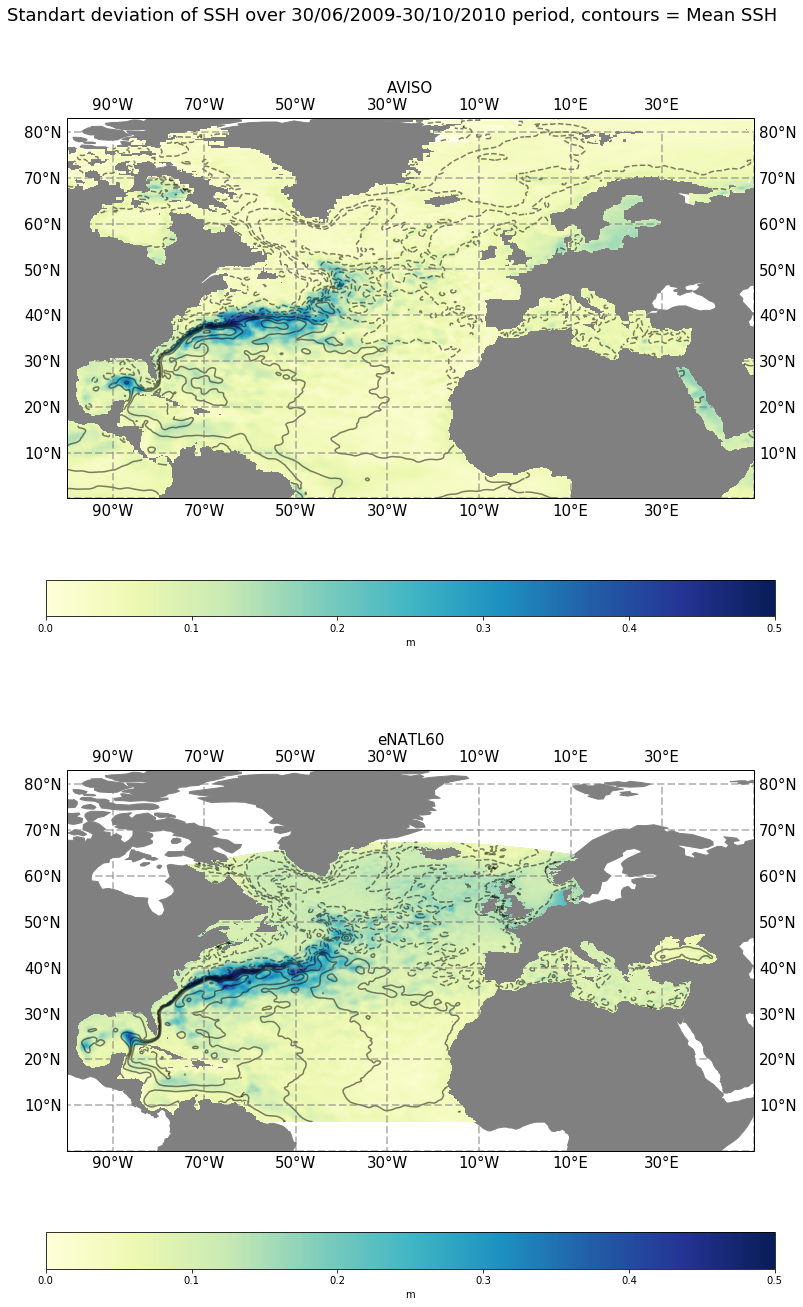

In [6]:
fig=plt.figure(figsize=(20,22))
ax = fig.add_subplot(211,projection=ccrs.PlateCarree())
ax.set_extent([-100, 50, 0, 65])

pcolor=ax.pcolormesh(grid_AVISO.longitude,grid_AVISO.latitude,ssh_std_AVISO.std_sossheig,transform=ccrs.PlateCarree(),cmap=mplcm.YlGnBu,vmin=0,vmax=0.5)

contour=ax.contour(grid_AVISO.longitude,grid_AVISO.latitude,ssh_mean_AVISO.mean_sossheig,np.arange(-1,1,0.15),colors='k',alpha=0.5,linewidth=0.0001,antialiased=True)

ax.add_feature(cfeature.LAND,facecolor='grey')
#ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
#gl.xlabels_top = False
#gl.ylabels_left = False

cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m')
ax.set_title('AVISO',size=15,y=1.05)

ax = fig.add_subplot(212,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-100, 50, 0, 65])

mask=np.squeeze(grid_eNATL6O.tmask)
data_ma=np.ma.masked_where(1-mask,ssh_std_eNATL60.std_sossheig)
pcolor=ax.pcolormesh(grid_eNATL6O.nav_lon,grid_eNATL6O.nav_lat,data_ma,transform=ccrs.PlateCarree(),cmap=mplcm.YlGnBu,vmin=0,vmax=0.5)

data_ma=np.ma.masked_where(1-mask,ssh_mean_eNATL60.mean_sossheig)

contour=ax.contour(grid_eNATL6O.nav_lon, grid_eNATL6O.nav_lat,data_ma,np.arange(-1,1,0.15),transform=ccrs.PlateCarree(),colors='k',alpha=0.5,linewidth=0.0001,antialiased=True)

ax.add_feature(cfeature.LAND,facecolor='grey')
#ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
#gl.xlabels_top = False
#gl.ylabels_left = False

cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m')
ax.set_title('eNATL60',size=15,y=1.05)


plt.suptitle('Standart deviation of SSH over 30/06/2009-30/10/2010 period, contours = Mean SSH',size=18,y=0.95,x=0.45)

plt.savefig('std-mean-SSH-AVISO-eNATL60-BLBT02.png')